In [392]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import matplotlib as mpl

import matplotlib.font_manager as fm



import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

In [393]:
# 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False


path = 'c:/Windows/Fonts/H2GTRE.TTF'
font_name = fm.FontProperties(fname= path).get_name()
rc('font',family =font_name)

##음수값 설정 
mpl.rcParams['axes.unicode_minus']=False

In [394]:
# ! pip install xlrd
# ! pip install openpyxl

In [395]:
df = pd.read_excel('./Al_data/7000_Al.xlsx', header=0)

df.head()

,class,Cr,Cu,Fe,Mg,Mn,Si,Ti,Zn,Zr,...,A,T4,T5,T6,T7,stress-relieved by stretching,AHT,UTS,YS,EL
0,7001-A,0.265,2.1,0.200,3.00,0.10,0.175,0.1,7.40,0.00,...,1,0,0,0,0,0,0,255.0,150.0,14.0
1,7001-T651,0.265,2.1,0.200,3.00,0.10,0.175,0.1,7.40,0.00,...,0,0,0,1,0,1,1,675.0,625.0,9.0
2,7001-T75,0.265,2.1,0.200,3.00,0.10,0.175,0.1,7.40,0.00,...,0,0,0,0,1,1,0,580.0,495.0,12.0
3,7003-T5,0.100,0.1,0.175,0.75,0.15,0.150,0.1,5.75,0.15,...,0,0,1,0,0,0,0,310.0,260.0,10.0
4,7003-T6,0.100,0.1,0.175,0.75,0.15,0.150,0.1,5.75,0.15,...,0,0,0,1,0,0,0,390.0,310.0,11.0


In [396]:
# 데이터 로딩 및 전처리
df = df.drop('class', axis=1)  # 'class' 열 삭제

In [397]:
df.fillna(0, inplace=True)

In [398]:
# 모든 값을 숫자 타입으로 변환
df = df.apply(pd.to_numeric, errors='coerce')

In [399]:
print(df.dtypes)

Cr                               float64
Cu                               float64
Fe                               float64
Mg                               float64
Mn                               float64
Si                               float64
Ti                               float64
Zn                               float64
Zr                               float64
Ni                               float64
V                                float64
O                                float64
A                                  int64
T4                                 int64
T5                                 int64
T6                                 int64
T7                                 int64
stress-relieved by stretching      int64
AHT                                int64
UTS                              float64
YS                               float64
EL                               float64
dtype: object


In [400]:
experiment_data = df[['Cr', 'Cu', 'Fe', 'Mg', 'Mn', 'Si', 'Ti', 'Zn', 'Zr', 'Ni', 'V', 'O']].values
scaler = StandardScaler()
normalized_experiment_data = scaler.fit_transform(experiment_data)


In [401]:
one_hot_encoded_data = df[['A', 'T4', 'T5', 'T6', 'T7', 'stress-relieved by stretching', 'AHT']].values
y = df[['UTS', 'YS', 'EL']].values

X_scaled = np.concatenate((normalized_experiment_data, one_hot_encoded_data), axis=1)

In [402]:
print(X_scaled.shape)
print(y.shape)

(138, 19)
(138, 3)


In [403]:
# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [404]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate

# 입력 레이어 정의
input_layer = Input(shape=(X_scaled.shape[1],), name='input')

# 은닉층 정의
hidden_layer = Dense(128, activation='relu')(input_layer)
hidden_layer = Dense(64, activation='relu')(hidden_layer)

# 출력층 정의
uts_output = Dense(1, name='uts_output')(hidden_layer)
ys_output = Dense(1, name='ys_output')(hidden_layer)
el_output = Dense(1, name='el_output')(hidden_layer)

# 다중 출력 모델 정의
model = Model(inputs=input_layer, outputs=[uts_output, ys_output, el_output])


In [405]:
# 손실 함수 정의
losses = {
    'uts_output': 'mean_squared_error',
    'ys_output': 'mean_squared_error',
    'el_output': 'mean_squared_error'
}

In [406]:
# 모델 컴파일
model.compile(optimizer='adam', loss=losses, metrics=['mae'])

# 모델 요약 정보 출력
model.summary()

Model: "model_1837"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 19)]         0           []                               
                                                                                                  
 dense_5492 (Dense)             (None, 128)          2560        ['input[0][0]']                  
                                                                                                  
 dense_5493 (Dense)             (None, 64)           8256        ['dense_5492[0][0]']             
                                                                                                  
 uts_output (Dense)             (None, 1)            65          ['dense_5493[0][0]']             
                                                                                         

In [407]:
# 모델 학습
history = model.fit(X_train, {'uts_output': y_train[:, 0], 'ys_output': y_train[:, 1], 'el_output': y_train[:, 2]}, epochs=500, batch_size=32, verbose=1, validation_data=(X_test, {'uts_output': y_test[:, 0], 'ys_output': y_test[:, 1], 'el_output': y_test[:, 2]}))


Epoch 1/500
4/4 [==============================] - 1s 95ms/step - loss: 449590.5000 - uts_output_loss: 252178.4531 - ys_output_loss: 197299.3438 - el_output_loss: 112.7036 - uts_output_mae: 488.8246 - ys_output_mae: 424.4713 - el_output_mae: 10.0468 - val_loss: 490721.2500 - val_uts_output_loss: 274636.2500 - val_ys_output_loss: 215996.0000 - val_el_output_loss: 88.9851 - val_uts_output_mae: 517.0425 - val_ys_output_mae: 457.9424 - val_el_output_mae: 9.1158
Epoch 2/500
4/4 [==============================] - 0s 14ms/step - loss: 448936.9062 - uts_output_loss: 251802.3125 - ys_output_loss: 197024.2656 - el_output_loss: 110.3209 - uts_output_mae: 488.4453 - ys_output_mae: 424.1546 - el_output_mae: 9.9243 - val_loss: 490032.9688 - val_uts_output_loss: 274256.0938 - val_ys_output_loss: 215689.9062 - val_el_output_loss: 86.9562 - val_uts_output_mae: 516.6744 - val_ys_output_mae: 457.6052 - val_el_output_mae: 9.0020
Epoch 3/500
4/4 [==============================] - 0s 14ms/step - loss: 44824

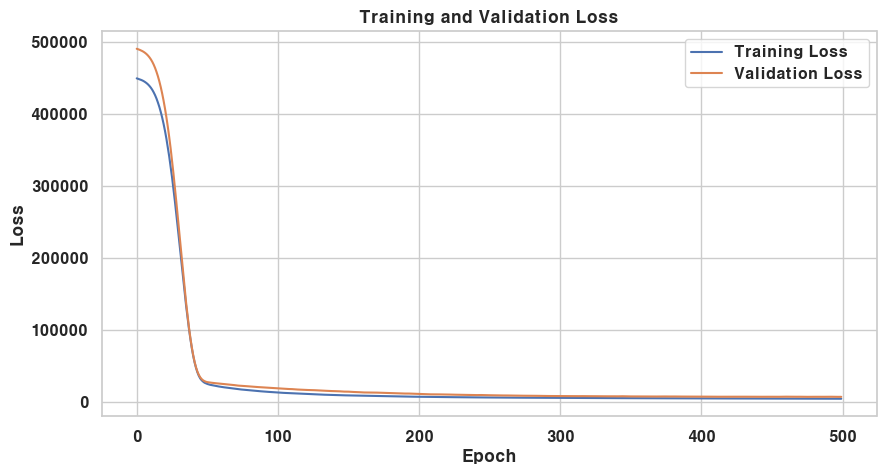

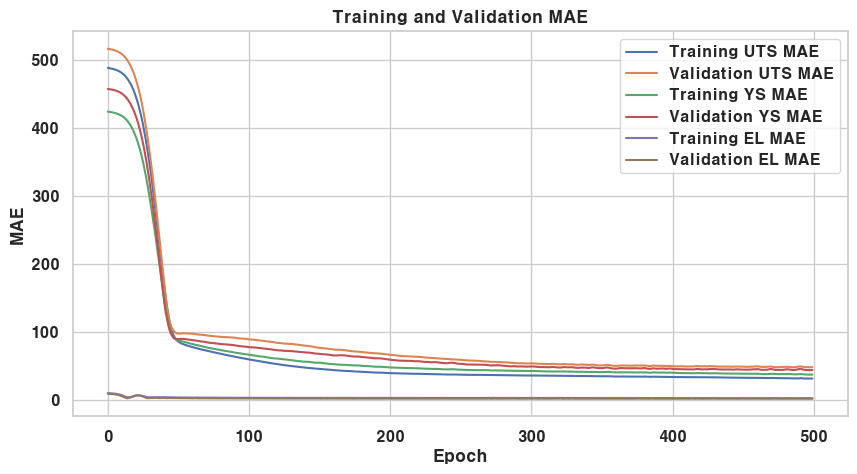

In [408]:
import matplotlib.pyplot as plt

# 학습 손실과 검증 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 학습 MAE와 검증 MAE 그래프
plt.figure(figsize=(10, 5))
plt.plot(history.history['uts_output_mae'], label='Training UTS MAE')
plt.plot(history.history['val_uts_output_mae'], label='Validation UTS MAE')
plt.plot(history.history['ys_output_mae'], label='Training YS MAE')
plt.plot(history.history['val_ys_output_mae'], label='Validation YS MAE')
plt.plot(history.history['el_output_mae'], label='Training EL MAE')
plt.plot(history.history['val_el_output_mae'], label='Validation EL MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()


5/5 [==============================] - 0s 2ms/step


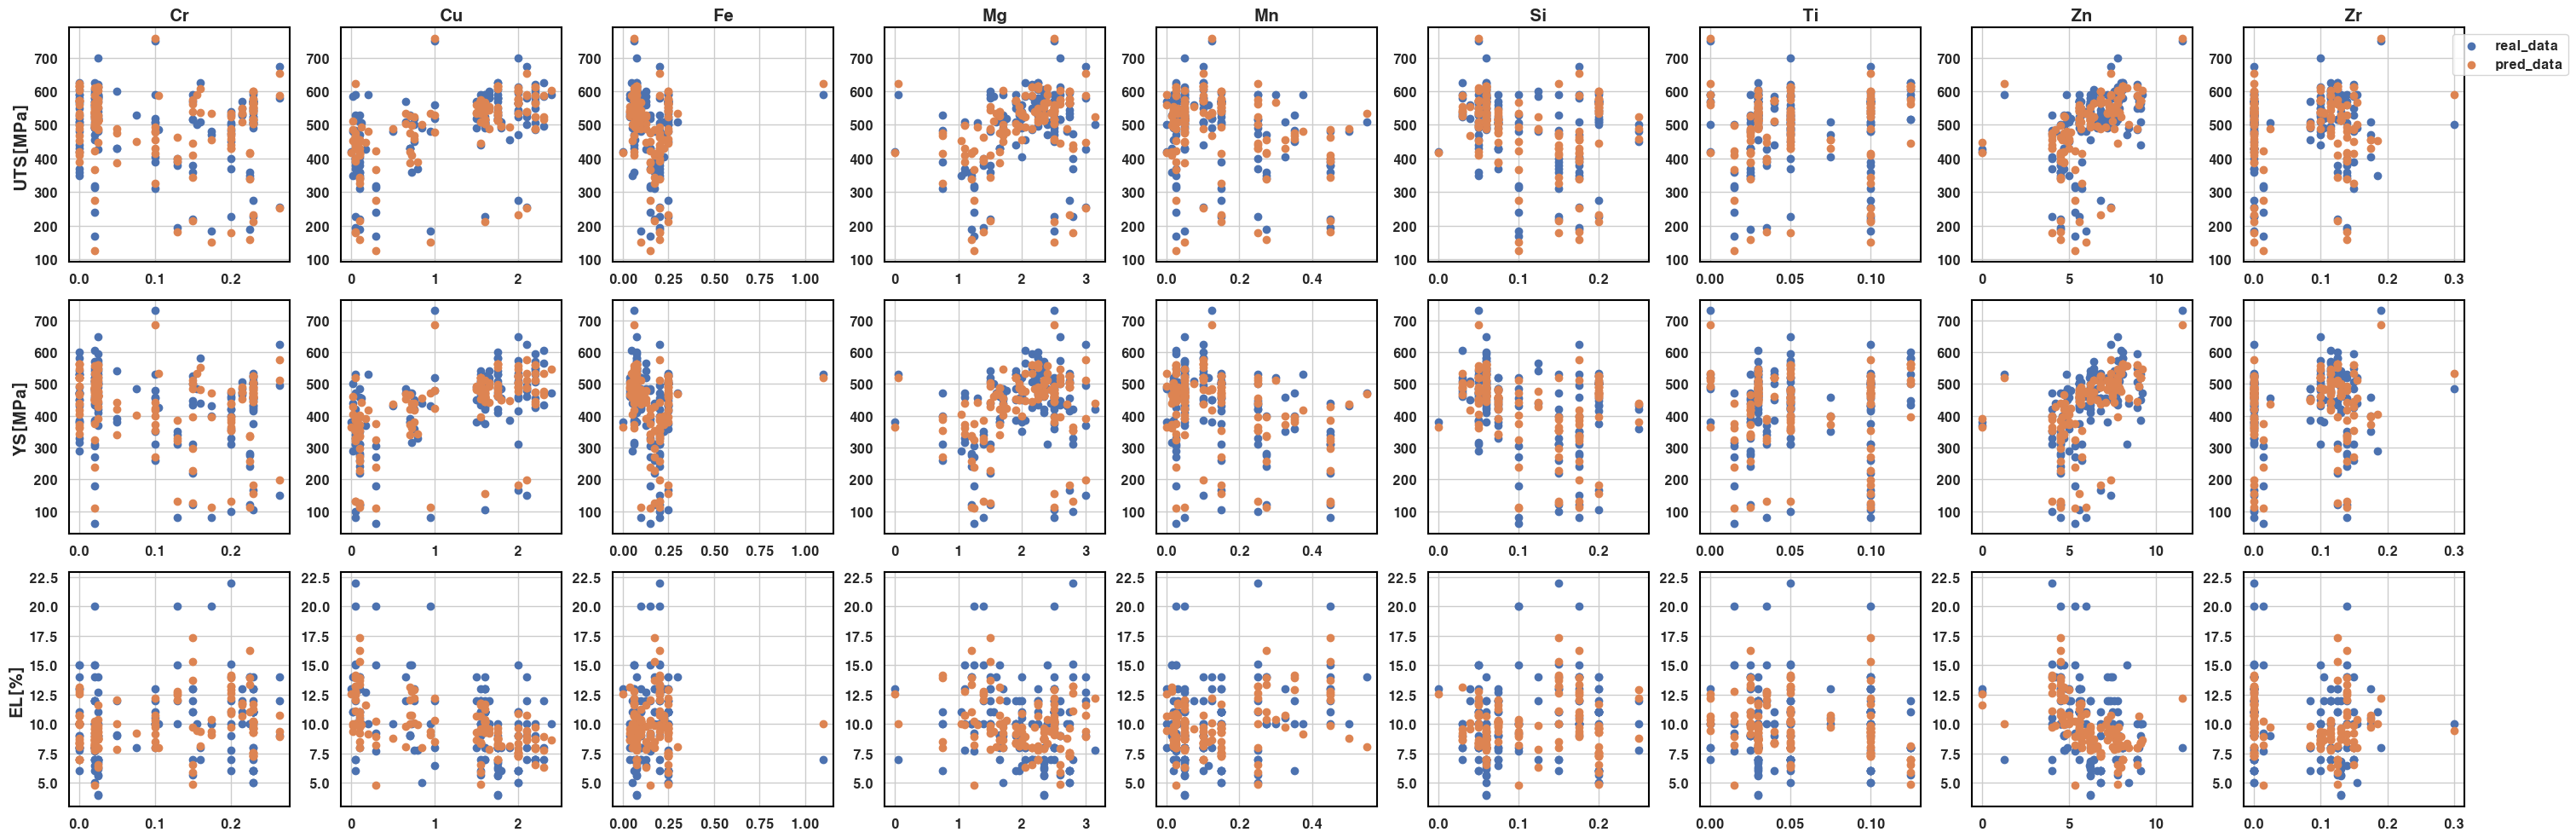

In [409]:
# 모델을 사용하여 예측값 얻기
predicted_values = model.predict(X_scaled)
predicted_uts = predicted_values[0][:, 0]

# 원소들의 인덱스와 이름
element_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]
element_names = ['Cr', 'Cu', 'Fe', 'Mg', 'Mn', 'Si', 'Ti', 'Zn', 'Zr']

# 3x9 서브플롯 그래프 그리기
fig, axs = plt.subplots(3, len(element_indices), figsize=(30, 10))

# 각 원소별로 그래프 그리기
for row, property_name in enumerate(['UTS[MPa]', 'YS[MPa]', 'EL[%]']):
    for col, element_idx in enumerate(element_indices):
        element_name = element_names[element_idx]
        ax = axs[row, col]
        
        if col == 0:
            ax.set_ylabel(property_name, fontsize=14, fontweight='bold')  # 왼쪽에 한 번만 bold체로 ylabel 설정
        if row == 0:
            ax.set_title(f'{element_name}', fontsize=14, fontweight='bold')  # 맨 위에 한 번만 bold체로 title 설정
        
        ax.scatter(experiment_data[:, element_idx], y[:, row], label='real_data')
        ax.scatter(experiment_data[:, element_idx], predicted_values[row], label='pred_data')
        
        # 테두리 선 색상 어둡게 설정
        for spine in ax.spines.values():
            spine.set_edgecolor('black')  # 색상 설정
            spine.set_linewidth(1.5)  # 굵기 설정
        
        # 맨 오른쪽 위 서브플롯에만 legend 추가
        if row == 0 and col == len(element_indices) - 1:
            ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), prop={'weight': 'bold'})  # 여기서 위치 조정

        # x, y 축 눈금 라벨 굵게 설정
        for label in ax.get_xticklabels():
            label.set_fontweight('bold')
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')

# 여백 조정
plt.subplots_adjust(right=0.8)  # 여백을 오른쪽으로 조정

plt.tight_layout()
plt.show()


5/5 [==============================] - 0s 2ms/step


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 34.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 39.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 42.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\seabor

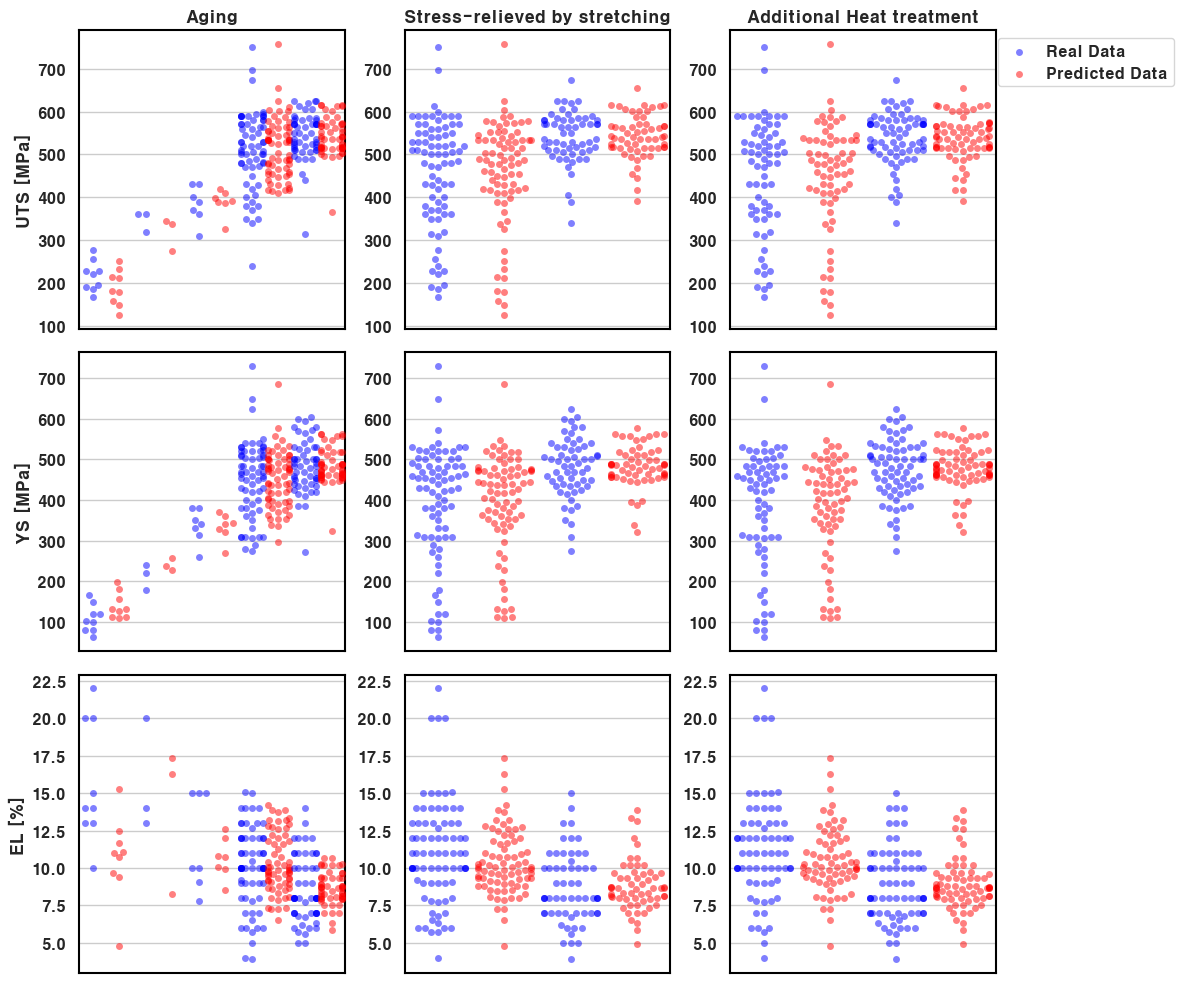

In [410]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.font_manager import FontProperties


# 속성명과 인덱스
attribute_names = ['A', 'T4', 'T5', 'T6', 'T7', 'stress-relieved by stretching', 'AHT']

# 'A', 'T4', 'T5', 'T6', 'T7' 속성의 인덱스 추출
attribute_indices_A_T7 = [attribute_names.index(attr) for attr in ['A', 'T4', 'T5', 'T6', 'T7']]

# 'stress-relieved by stretching' 속성의 인덱스 추출
attribute_index_stress_relieved = attribute_names.index('stress-relieved by stretching')

# 'AHT' 속성의 인덱스 추출
attribute_index_AHT = attribute_names.index('AHT')

# 모델의 예측값 얻기
predicted_values = model.predict(X_scaled)
predicted_uts = predicted_values[0][:, 0]
predicted_ys = predicted_values[1][:, 0]
predicted_el = predicted_values[2][:, 0]

# 3x3 figure 생성
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

# Bold체 폰트 생성
bold_font = {'fontweight': 'bold'}


# Legend 폰트 생성
legend_font = FontProperties(weight='bold')

# 'A', 'T4', 'T5', 'T6', 'T7' 속성의 UTS, YS, EL 값 (swarmplot)
for row in range(3):
    for col, attr_idx in enumerate(attribute_indices_A_T7):
        attribute_name = attribute_names[attr_idx]
        real_data = y[:, row]
        predicted_data = predicted_uts if row == 0 else predicted_ys if row == 1 else predicted_el
        mask = (X_scaled[:, normalized_experiment_data.shape[1] + attr_idx] == 1)
        
        axs[row, 0].set_ylabel('UTS [MPa]' if row == 0 else 'YS [MPa]' if row == 1 else 'EL [%]', **bold_font)
        
        sns.swarmplot(x=np.repeat(f"{attribute_name} (Real)", np.sum(mask)), y=real_data[mask], ax=axs[row, 0], color='blue', alpha=0.5, label='Real Data', legend=False)
        sns.swarmplot(x=np.repeat(f"{attribute_name} (Predicted)", np.sum(mask)), y=predicted_data[mask], ax=axs[row, 0], color='red', alpha=0.5, label='Predicted Data', legend=False)

    # xticklabels 없애기
    axs[row, 0].set_xticklabels([])
    
    # y ticks label 굵게 설정
    for label in axs[row, 0].get_yticklabels():
        label.set_fontweight('bold')
    
    # xticks 없애기
    axs[row, 0].set_xticks([])

# ...

# 'stress-relieved by stretching' 속성의 UTS, YS, EL 값 (swarmplot)
for row in range(3):
    real_data = y[:, row]
    predicted_data = predicted_uts if row == 0 else predicted_ys if row == 1 else predicted_el

    # 속성값이 0인 데이터 플롯 (Real)
    mask_0 = (X_scaled[:, normalized_experiment_data.shape[1] + attribute_index_stress_relieved] == 0)
    sns.swarmplot(x=np.repeat('stress-relieved by stretching (0) (Real)', np.sum(mask_0)), y=real_data[mask_0], ax=axs[row, 1], color='blue', alpha=0.5, label='Real Data', legend=False)

    # 속성값이 0인 데이터 플롯 (Predicted)
    sns.swarmplot(x=np.repeat('stress-relieved by stretching (0) (Predicted)', np.sum(mask_0)), y=predicted_data[mask_0], ax=axs[row, 1], color='red', alpha=0.5, label='Predicted Data', legend=False)

    # 속성값이 1인 데이터 플롯 (Real)
    mask_1 = (X_scaled[:, normalized_experiment_data.shape[1] + attribute_index_stress_relieved] == 1)
    sns.swarmplot(x=np.repeat('stress-relieved by stretching (1) (Real)', np.sum(mask_1)), y=real_data[mask_1], ax=axs[row, 1], color='blue', alpha=0.5, legend=False)

    # 속성값이 1인 데이터 플롯 (Predicted)
    sns.swarmplot(x=np.repeat('stress-relieved by stretching (1) (Predicted)', np.sum(mask_1)), y=predicted_data[mask_1], ax=axs[row, 1], color='red', alpha=0.5, legend=False)
    
    # xticklabels 없애기
    axs[row, 1].set_xticklabels([])
    
    # y ticks label 굵게 설정
    for label in axs[row, 1].get_yticklabels():
        label.set_fontweight('bold')
    
    # xticks 없애기
    axs[row, 1].set_xticks([])

# ...

# 'AHT' 속성의 UTS, YS, EL 값 (swarmplot)
for row in range(3):
    attribute_name = 'AHT'
    real_data = y[:, row]
    predicted_data = predicted_uts if row == 0 else predicted_ys if row == 1 else predicted_el

    # 속성값이 0인 데이터 플롯 (Real)
    mask_0 = (X_scaled[:, normalized_experiment_data.shape[1] + attribute_index_AHT] == 0)
    sns.swarmplot(x=np.repeat('AHT (0) (Real)', np.sum(mask_0)), y=real_data[mask_0], ax=axs[row, 2], color='blue', alpha=0.5, label='Real Data', legend=False)

    # 속성값이 0인 데이터 플롯 (Predicted)
    sns.swarmplot(x=np.repeat('AHT (0) (Predicted)', np.sum(mask_0)), y=predicted_data[mask_0], ax=axs[row, 2], color='red', alpha=0.5, label='Predicted Data', legend=False)

    # 속성값이 1인 데이터 플롯 (Real)
    mask_1 = (X_scaled[:, normalized_experiment_data.shape[1] + attribute_index_AHT] == 1)
    sns.swarmplot(x=np.repeat('AHT (1) (Real)', np.sum(mask_1)), y=real_data[mask_1], ax=axs[row, 2], color='blue', alpha=0.5, legend=False)

    # 속성값이 1인 데이터 플롯 (Predicted)
    sns.swarmplot(x=np.repeat('AHT (1) (Predicted)', np.sum(mask_1)), y=predicted_data[mask_1], ax=axs[row, 2], color='red', alpha=0.5, legend=False)

    # xticklabels 없애기
    axs[row, 2].set_xticklabels([])
    
    # y ticks label 굵게 설정
    for label in axs[row, 2].get_yticklabels():
        label.set_fontweight('bold')
    
    # xticks 없애기
    axs[row, 2].set_xticks([])

# 범례 설정은 ax[0,2]에만 적용
axs[0, 2].legend(loc='upper right', bbox_to_anchor=(1.7, 1.0), prop={'weight': 'bold'})

# 테두리를 검은색으로 설정
for ax in axs.flat:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')  # 테두리 색상 설정
        spine.set_linewidth(1.5)  # 테두리 굵기 설정

# 서브플롯의 제목 설정
axs[0, 0].set_title('Aging', fontweight='bold')
axs[0, 1].set_title('Stress-relieved by stretching', fontweight='bold')
axs[0, 2].set_title('Additional Heat treatment', fontweight='bold')


plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 21ms/step


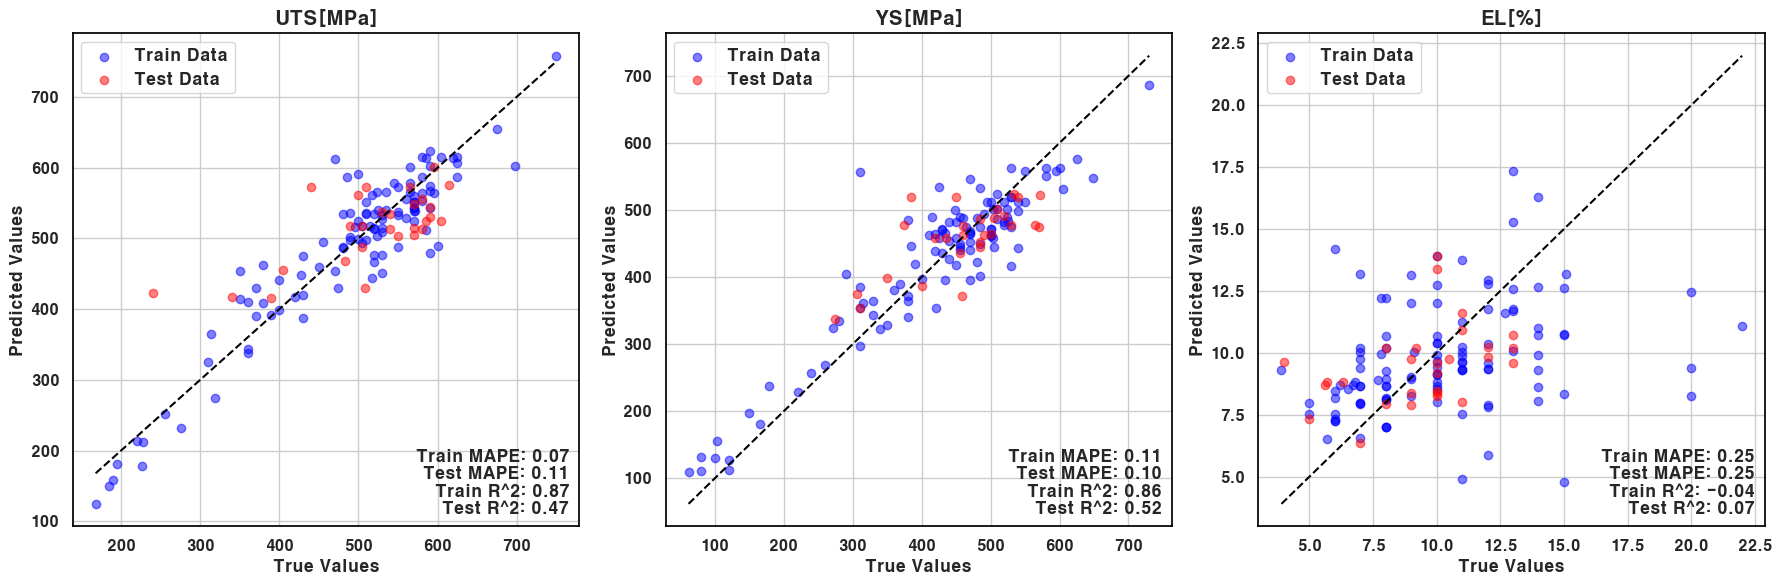

In [411]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from matplotlib.font_manager import FontProperties

def plot_and_evaluate_combined(y_train_true, y_train_pred, y_test_true, y_test_pred, title, ax):
    ax.scatter(y_train_true, y_train_pred, color='blue', alpha=0.5, label='Train Data')
    ax.scatter(y_test_true, y_test_pred, color='red', alpha=0.5, label='Test Data')
    ax.plot([min(y_train_true), max(y_train_true)], [min(y_train_true), max(y_train_true)], linestyle='--', color='black')
    ax.set_title(title, fontsize=14, fontweight='bold')  # 글꼴 굵게 설정
    ax.set_xlabel('True Values', fontsize=12, fontweight='bold')  # 글꼴 굵게 설정
    ax.set_ylabel('Predicted Values', fontsize=12, fontweight='bold')  # 글꼴 굵게 설정
    ax.grid(True)
    legend_font = FontProperties(weight='bold')
    
        # x, y 축 눈금 라벨 글꼴 굵게 설정
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
        
        # 테두리 선 굵기 설정
    for spine in ax.spines.values():
        spine.set_edgecolor('black')  # 색상 설정
    
    # 계산된 MAPE 및 R^2 값
    train_mape = mean_absolute_percentage_error(y_train_true, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test_true, y_test_pred)
    
    train_r2 = r2_score(y_train_true, y_train_pred)
    test_r2 = r2_score(y_test_true, y_test_pred)
    
    text = f'Train MAPE: {train_mape:.2f}\nTest MAPE: {test_mape:.2f}\nTrain R^2: {train_r2:.2f}\nTest R^2: {test_r2:.2f}'
    
    ax.annotate(text, xy=(0.98, 0.02), xycoords='axes fraction', fontsize=12, fontweight='bold', verticalalignment='bottom', horizontalalignment='right')
    ax.legend(prop=legend_font)

# 훈련 데이터에 대한 예측값 계산
predicted_train_values = model.predict(X_train)
predicted_train_uts = predicted_train_values[0][:, 0]
predicted_train_ys = predicted_train_values[1][:, 0]
predicted_train_el = predicted_train_values[2][:, 0]

# 테스트 데이터에 대한 예측값 계산
predicted_test_values = model.predict(X_test)
predicted_test_uts = predicted_test_values[0][:, 0]
predicted_test_ys = predicted_test_values[1][:, 0]
predicted_test_el = predicted_test_values[2][:, 0]

# 1x3 subplot으로 산점도 및 평가 표시
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plot_and_evaluate_combined(y_train[:, 0], predicted_train_uts, y_test[:, 0], predicted_test_uts, 'UTS[MPa]', axs[0])
plot_and_evaluate_combined(y_train[:, 1], predicted_train_ys, y_test[:, 1], predicted_test_ys, 'YS[MPa]', axs[1])
plot_and_evaluate_combined(y_train[:, 2], predicted_train_el, y_test[:, 2], predicted_test_el, 'EL[%]', axs[2])

plt.tight_layout()
plt.show()


In [412]:
# ! pip install scikit-optimize
# ! pip install bayesian-optimization

In [413]:
from skopt import BayesSearchCV
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Dense, Input
from skopt.space import Real, Integer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
import numpy as np


# Define the function to create the DNN model
def create_model(learning_rate, units1, units2, dropout_rate):
    input_layer = Input(shape=(X_train.shape[1],))
    hidden_layer = Dense(units1, activation='relu')(input_layer)
    hidden_layer = Dropout(dropout_rate)(hidden_layer)
    hidden_layer = Dense(units2, activation='relu')(hidden_layer)
    output_layer = Dense(3)(hidden_layer)  # 3 outputs for UTS, YS, EL
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    return model

# Create KerasRegressor with create_model function and its parameters
keras_regressor = KerasRegressor(
    build_fn=create_model,
    learning_rate=0.001,  # Specify default values for hyperparameters
    units1=64,
    units2=64,
    dropout_rate=0.0,
    verbose=0
)

# Define the search space for hyperparameters
param_space = {
    'learning_rate': Real(1e-5, 1e-1, prior='log-uniform'),
    'units1': Integer(16, 256),
    'units2': Integer(16, 256),
    'dropout_rate': Real(0.0, 0.5)
}

# Define BayesSearchCV with KerasRegressor
bayes_search = BayesSearchCV(
    keras_regressor,
    param_space,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    verbose=1,
    refit=False
)

# Perform Bayesian Optimization
bayes_search.fit(X_train, y_train)

# Print best hyperparameters
print("Best hyperparameters:", bayes_search.best_params_)

C:\Users\rhkr3\AppData\Local\Temp\ipykernel_16008\2816303909.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_regressor = KerasRegressor(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [414]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Dense, Input
from tensorflow.keras.models import Model
import numpy as np

# Load and preprocess your data here
# ...

# Best hyperparameters from Bayesian Optimization
best_hyperparams = bayes_search.best_params_

# Define the function to create the DNN model
def create_model(learning_rate, units1, units2, dropout_rate):
    input_layer = Input(shape=(X_train.shape[1],))
    hidden_layer = Dense(units1, activation='relu')(input_layer)
    hidden_layer = Dropout(dropout_rate)(hidden_layer)
    hidden_layer = Dense(units2, activation='relu')(hidden_layer)
    output_layer = Dense(3)(hidden_layer)  # 3 outputs for UTS, YS, EL
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    return model

# Create the model with best hyperparameters
best_model = create_model(
    learning_rate=best_hyperparams['learning_rate'],
    units1=best_hyperparams['units1'],
    units2=best_hyperparams['units2'],
    dropout_rate=best_hyperparams['dropout_rate']
)

# Train the model manually
history_best = best_model.fit(
    X_train, y_train,
    epochs=500, batch_size=32, verbose=1,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the test set
eval_results = best_model.evaluate(X_test, y_test)
print("Test Loss:", eval_results[0])
print("Test MAE:", eval_results[1])

Epoch 1/500
4/4 [==============================] - 1s 55ms/step - loss: 109288.6328 - mae: 252.8989 - val_loss: 144353.2031 - val_mae: 282.0100
Epoch 2/500
4/4 [==============================] - 0s 14ms/step - loss: 68973.2500 - mae: 174.7268 - val_loss: 71861.7891 - val_mae: 213.5916
Epoch 3/500
4/4 [==============================] - 0s 14ms/step - loss: 74256.3281 - mae: 210.4571 - val_loss: 74932.0703 - val_mae: 217.2400
Epoch 4/500
4/4 [==============================] - 0s 15ms/step - loss: 44957.1094 - mae: 154.2984 - val_loss: 26185.6250 - val_mae: 106.5896
Epoch 5/500
4/4 [==============================] - 0s 15ms/step - loss: 39501.3828 - mae: 136.6698 - val_loss: 6834.5596 - val_mae: 59.1473
Epoch 6/500
4/4 [==============================] - 0s 14ms/step - loss: 21653.4180 - mae: 102.3277 - val_loss: 38053.4688 - val_mae: 144.5613
Epoch 7/500
4/4 [==============================] - 0s 16ms/step - loss: 29298.7910 - mae: 119.9238 - val_loss: 12575.6309 - val_mae: 78.9270
Epoch 8

In [365]:
# # Create an empty list to store the results
# results = []

# # Number of experiments
# num_experiments = 5

# for _ in range(num_experiments):
#     optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)
#     optimizer.maximize(init_points=20, n_iter=50)
#     best_params = optimizer.max['params']
#     results.append(best_params)

# # Create lists to store loss and epoch values for each experiment
# loss_values = []
# epoch_values = []

# # Iterate over the results of each experiment
# for i, best_params in enumerate(results):
#     model_bayesian = build_model(best_params['learning_rate'], int(best_params['units_layer1']),
#                         int(best_params['units_layer2']), best_params['dropout_rate'])
#     history_bayesian = model_bayesian.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1)
    
#     # Append loss and epoch values to lists
#     loss_values.append(history_bayesian.history['loss'])
#     epoch_values.append(range(1, len(history_bayesian.history['loss']) + 1))




|   iter    |  target   | dropou... | learni... | units_... | units_... |
-------------------------------------------------------------------------
1/1 [==============================] - 0s 48ms/step
| 1         | -2.506e+0 | 0.1873    | 0.09512   | 102.3     | 89.47     |
1/1 [==============================] - 0s 45ms/step
| 2         | -2.543e+0 | 0.07801   | 0.01644   | 37.58     | 115.2     |
1/1 [==============================] - 0s 49ms/step
| 3         | -2.971e+0 | 0.3006    | 0.0711    | 33.98     | 125.1     |
1/1 [==============================] - 0s 49ms/step
| 4         | -2.461e+0 | 0.4162    | 0.02202   | 49.46     | 49.61     |
1/1 [==============================] - 0s 49ms/step
| 5         | -2.316e+0 | 0.1521    | 0.05295   | 73.47     | 59.96     |
1/1 [==============================] - 0s 47ms/step
| 6         | -2.688e+0 | 0.3059    | 0.01481   | 60.05     | 67.17     |
1/1 [==============================] - 0s 55ms/step
| 7         | -3.284e+0 | 0.228     | 0.0787

In [375]:
# # Assuming 'BayesianOptimization', 'objective', 'pbounds', and 'build_model' are correctly defined

# # Create an empty list to store the results
# results = []

# # Number of experiments
# num_experiments = 5

# for _ in range(num_experiments):
#     optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)
#     optimizer.maximize(init_points=20, n_iter=50)
#     best_params = optimizer.max['params']
#     results.append(best_params)

# # Create lists to store loss and epoch values for each experiment
# loss_values = []
# epoch_values = []

# # Iterate over the results of each experiment
# for i, best_params in enumerate(results):
#     model_bayesian = build_model(best_params['learning_rate'], int(best_params['units_layer1']),
#                         int(best_params['units_layer2']), best_params['dropout_rate'])
#     history_bayesian = model_bayesian.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1)
    
#     # Append loss and epoch values to lists
#     loss_values.append(history_bayesian.history['loss'])
#     epoch_values.append(range(1, len(history_bayesian.history['loss']) + 1))


|   iter    |  target   | dropou... | learni... | units_... | units_... |
-------------------------------------------------------------------------
1/1 [==============================] - 0s 50ms/step
| 1         | -3.082e+0 | 0.1873    | 0.09512   | 102.3     | 89.47     |
1/1 [==============================] - 0s 49ms/step
| 2         | -2.852e+0 | 0.07801   | 0.01644   | 37.58     | 115.2     |
1/1 [==============================] - 0s 47ms/step
| 3         | -2.288e+0 | 0.3006    | 0.0711    | 33.98     | 125.1     |
1/1 [==============================] - 0s 49ms/step
| 4         | -2.513e+0 | 0.4162    | 0.02202   | 49.46     | 49.61     |
1/1 [==============================] - 0s 42ms/step
| 5         | -2.38e+03 | 0.1521    | 0.05295   | 73.47     | 59.96     |
1/1 [==============================] - 0s 42ms/step
| 6         | -2.994e+0 | 0.3059    | 0.01481   | 60.05     | 67.17     |
1/1 [==============================] - 0s 43ms/step
| 7         | -2.679e+0 | 0.228     | 0.0787

In [377]:
# from tensorflow.keras.layers import Dense

# # Extract the best hyperparameters
# best_params = optimizer.max['params']
# best_learning_rate = best_params['learning_rate']
# best_units_layer1 = int(best_params['units_layer1'])
# best_units_layer2 = int(best_params['units_layer2'])
# best_dropout_rate = best_params['dropout_rate']

# # Build the best model using the best hyperparameters
# model_bayesian = build_model(best_learning_rate, best_units_layer1, best_units_layer2, best_dropout_rate)

# # Add the output layers with the correct names
# uts_output = Dense(1, name='uts_output')(model_bayesian.layers[-3].output)
# ys_output = Dense(1, name='ys_output')(model_bayesian.layers[-2].output)
# el_output = Dense(1, name='el_output')(model_bayesian.layers[-1].output)

# # Create a new model with the updated outputs
# model_bayesian = Model(inputs=model_bayesian.input, outputs=[uts_output, ys_output, el_output])

# # Compile the model with appropriate loss functions for each output
# model_bayesian.compile(optimizer='adam', loss={'uts_output': 'mean_squared_error', 'ys_output': 'mean_squared_error', 'el_output': 'mean_squared_error'}, metrics=['mae'])

# # 모델 학습 (model_bayesian)
# history_bayesian = model_bayesian.fit(
#     X_train, {'uts_output': y_train[:, 0], 'ys_output': y_train[:, 1], 'el_output': y_train[:, 2]},
#     epochs=500, batch_size=32, verbose=1,
#     validation_data=(X_test, {'uts_output': y_test[:, 0], 'ys_output': y_test[:, 1], 'el_output': y_test[:, 2]}),
#     callbacks=[tf.keras.callbacks.History()]
# )


Epoch 1/500
4/4 [==============================] - 2s 87ms/step - loss: 449595.5000 - uts_output_loss: 252612.2188 - ys_output_loss: 196867.3125 - el_output_loss: 115.9676 - uts_output_mae: 489.2629 - ys_output_mae: 423.9699 - el_output_mae: 10.2165 - val_loss: 490997.0000 - val_uts_output_loss: 275260.8438 - val_ys_output_loss: 215644.4062 - val_el_output_loss: 91.7475 - val_uts_output_mae: 517.6241 - val_ys_output_mae: 457.5509 - val_el_output_mae: 9.2790
Epoch 2/500
4/4 [==============================] - 0s 15ms/step - loss: 449178.4375 - uts_output_loss: 252491.5156 - ys_output_loss: 196572.7969 - el_output_loss: 114.1608 - uts_output_mae: 489.1438 - ys_output_mae: 423.6283 - el_output_mae: 10.1259 - val_loss: 490608.1562 - val_uts_output_loss: 275150.3125 - val_ys_output_loss: 215367.6250 - val_el_output_loss: 90.1836 - val_uts_output_mae: 517.5179 - val_ys_output_mae: 457.2425 - val_el_output_mae: 9.1930
Epoch 3/500
4/4 [==============================] - 0s 16ms/step - loss: 4487

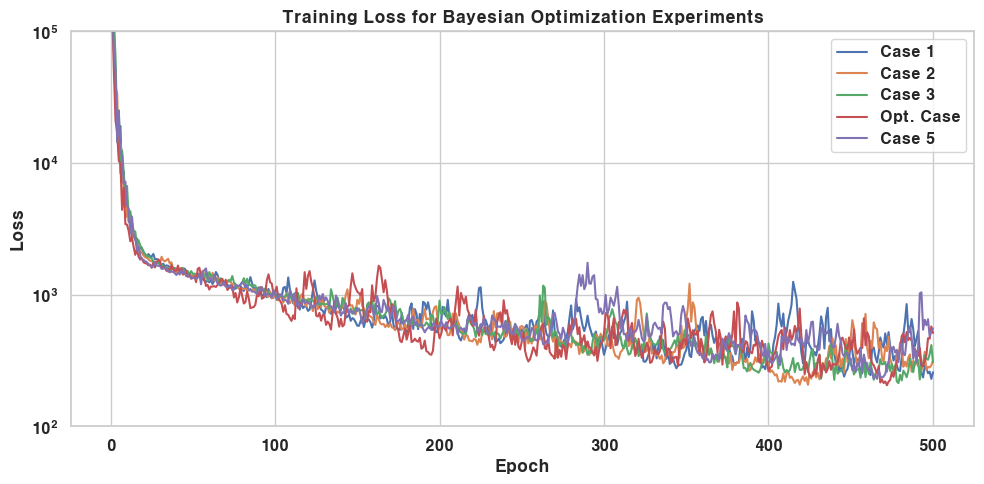

   dropout_rate  learning_rate  units_layer1  units_layer2
0      0.495642       0.061327     48.811578     40.873392
1      0.123402       0.026561    124.848310     82.730497
2      0.415934       0.028986     68.637144     58.548928
3      0.030709       0.052083     72.997622    123.480787
4      0.192628       0.061825     33.014300    107.678371


In [378]:
# # Find the index of the experiment with the lowest loss
# best_experiment_idx = np.argmin([min(loss) for loss in loss_values])

# # Create a figure and axis for the combined graph
# combined_fig, combined_ax = plt.subplots(figsize=(10, 5))

# # Iterate over the experiments and plot loss vs epoch graph
# for i, (loss, epochs) in enumerate(zip(loss_values, epoch_values)):
#     label = f'Case {i+1}' if i != best_experiment_idx else 'Opt. Case'
#     combined_ax.plot(epochs, loss, label=label)

# combined_ax.set_title('Training Loss for Bayesian Optimization Experiments')
# combined_ax.set_xlabel('Epoch')
# combined_ax.set_ylabel('Loss')
# combined_ax.legend()

# # Set y axis scale to log
# combined_ax.set_yscale('log')
# combined_ax.set_ylim([100, 100000])  # Set the desired y value range

# plt.tight_layout()
# plt.show()

# # Convert the results list to a DataFrame
# results_df = pd.DataFrame(results)

# # Print the DataFrame
# print(results_df)

In [415]:
best_model.summary()

Model: "model_1838"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1829 (InputLayer)     [(None, 19)]              0         
                                                                 
 dense_5494 (Dense)          (None, 97)                1940      
                                                                 
 dropout (Dropout)           (None, 97)                0         
                                                                 
 dense_5495 (Dense)          (None, 123)               12054     
                                                                 
 dense_5496 (Dense)          (None, 3)                 372       
                                                                 
Total params: 14,366
Trainable params: 14,366
Non-trainable params: 0
_________________________________________________________________


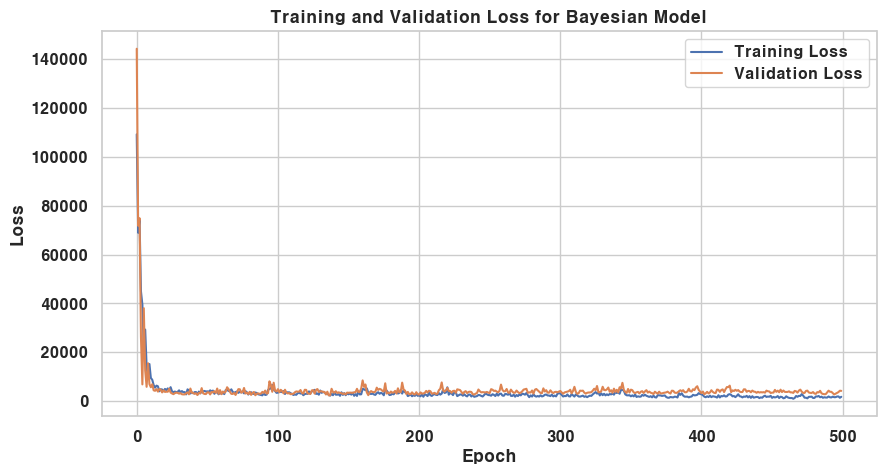

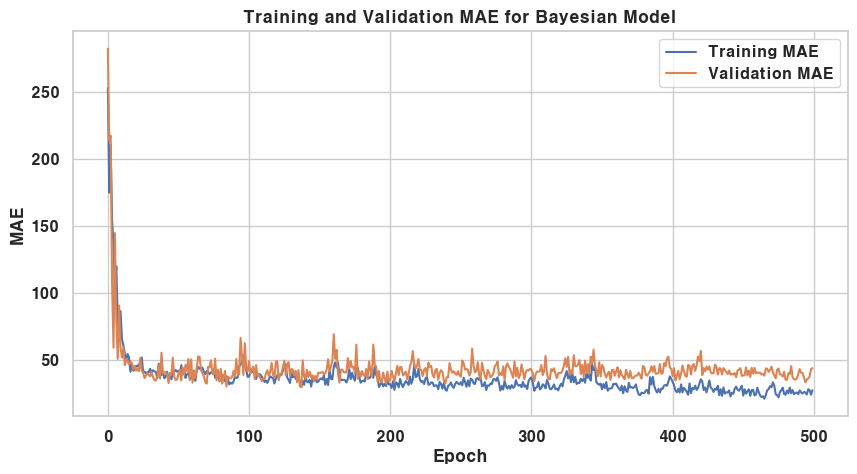

In [420]:
# 학습 손실과 검증 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(history_best.history['loss'], label='Training Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Bayesian Model')
plt.legend()
plt.show()

# 학습 MAE와 검증 MAE 그래프
plt.figure(figsize=(10, 5))
plt.plot(history_best.history['mae'], label='Training MAE')
plt.plot(history_best.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE for Bayesian Model')
plt.legend()
plt.show()


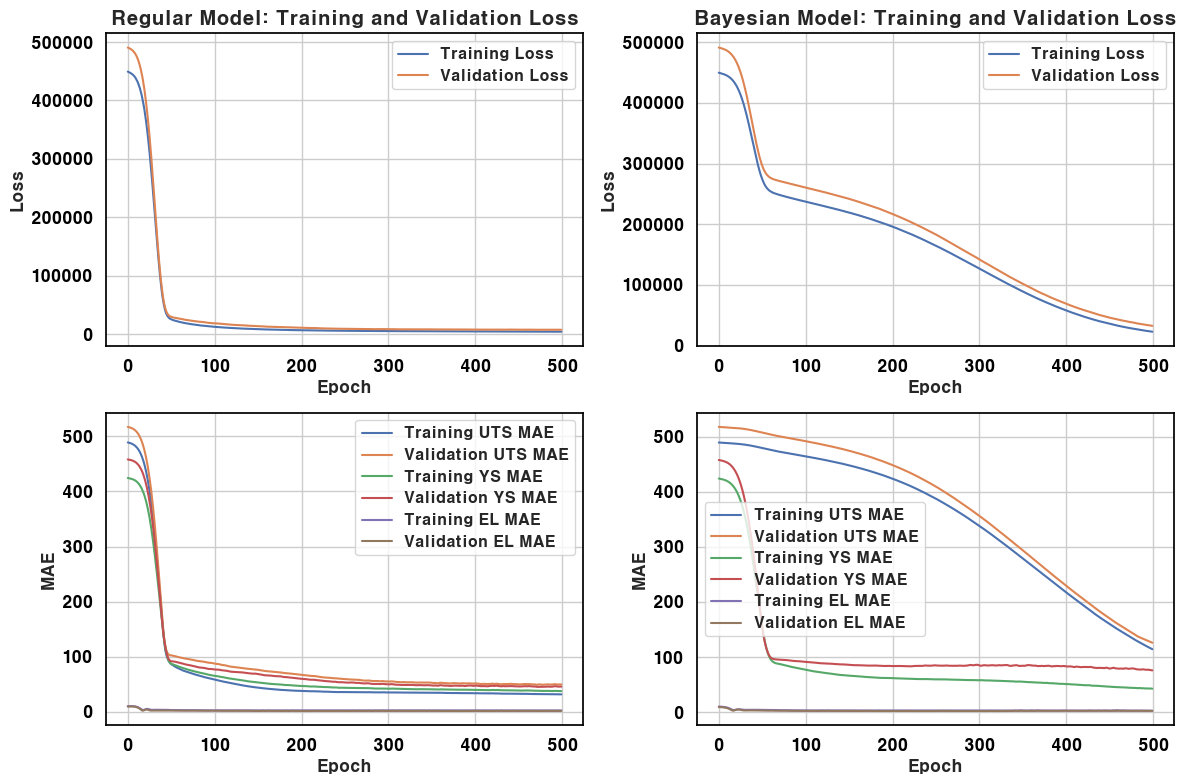

In [382]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # 전체 그림의 크기 설정

# Regular Model: Loss vs Epoch
plt.subplot(2, 2, 1)  # 2행 2열의 첫 번째 그래프
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.title('Regular Model: Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.tick_params(axis='both', which='both', color='black', labelcolor='black', width=2, labelsize=12)

# Bayesian Model: Loss vs Epoch
plt.subplot(2, 2, 2)  # 2행 2열의 세 번째 그래프
plt.plot(history_bayesian.history['loss'], label='Training Loss')
plt.plot(history_bayesian.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.title('Bayesian Model: Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.tick_params(axis='both', which='both', color='black', labelcolor='black', width=2, labelsize=12)


# Regular Model: MAE vs Epoch
plt.subplot(2, 2, 3)  # 2행 2열의 세 번째 그래프
plt.plot(history.history['uts_output_mae'], label='Training UTS MAE')
plt.plot(history.history['val_uts_output_mae'], label='Validation UTS MAE')
plt.plot(history.history['ys_output_mae'], label='Training YS MAE')
plt.plot(history.history['val_ys_output_mae'], label='Validation YS MAE')
plt.plot(history.history['el_output_mae'], label='Training EL MAE')
plt.plot(history.history['val_el_output_mae'], label='Validation EL MAE')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('MAE', fontweight='bold')
# plt.title('Regular Model: Training and Validation MAE', fontsize=14, fontweight='bold')
plt.legend()
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.tick_params(axis='both', which='both', color='black', labelcolor='black', width=2, labelsize=12)

# Bayesian Model: MAE vs Epoch
plt.subplot(2, 2, 4)  # 2행 2열의 네 번째 그래프
plt.plot(history_bayesian.history['uts_output_mae'], label='Training UTS MAE')
plt.plot(history_bayesian.history['val_uts_output_mae'], label='Validation UTS MAE')
plt.plot(history_bayesian.history['ys_output_mae'], label='Training YS MAE')
plt.plot(history_bayesian.history['val_ys_output_mae'], label='Validation YS MAE')
plt.plot(history_bayesian.history['el_output_mae'], label='Training EL MAE')
plt.plot(history_bayesian.history['val_el_output_mae'], label='Validation EL MAE')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('MAE', fontweight='bold')
# plt.title('Bayesian Model: Training and Validation MAE', fontsize=14, fontweight='bold')
plt.legend()
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.tick_params(axis='both', which='both', color='black', labelcolor='black', width=2, labelsize=12)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


5/5 [==============================] - 0s 7ms/step


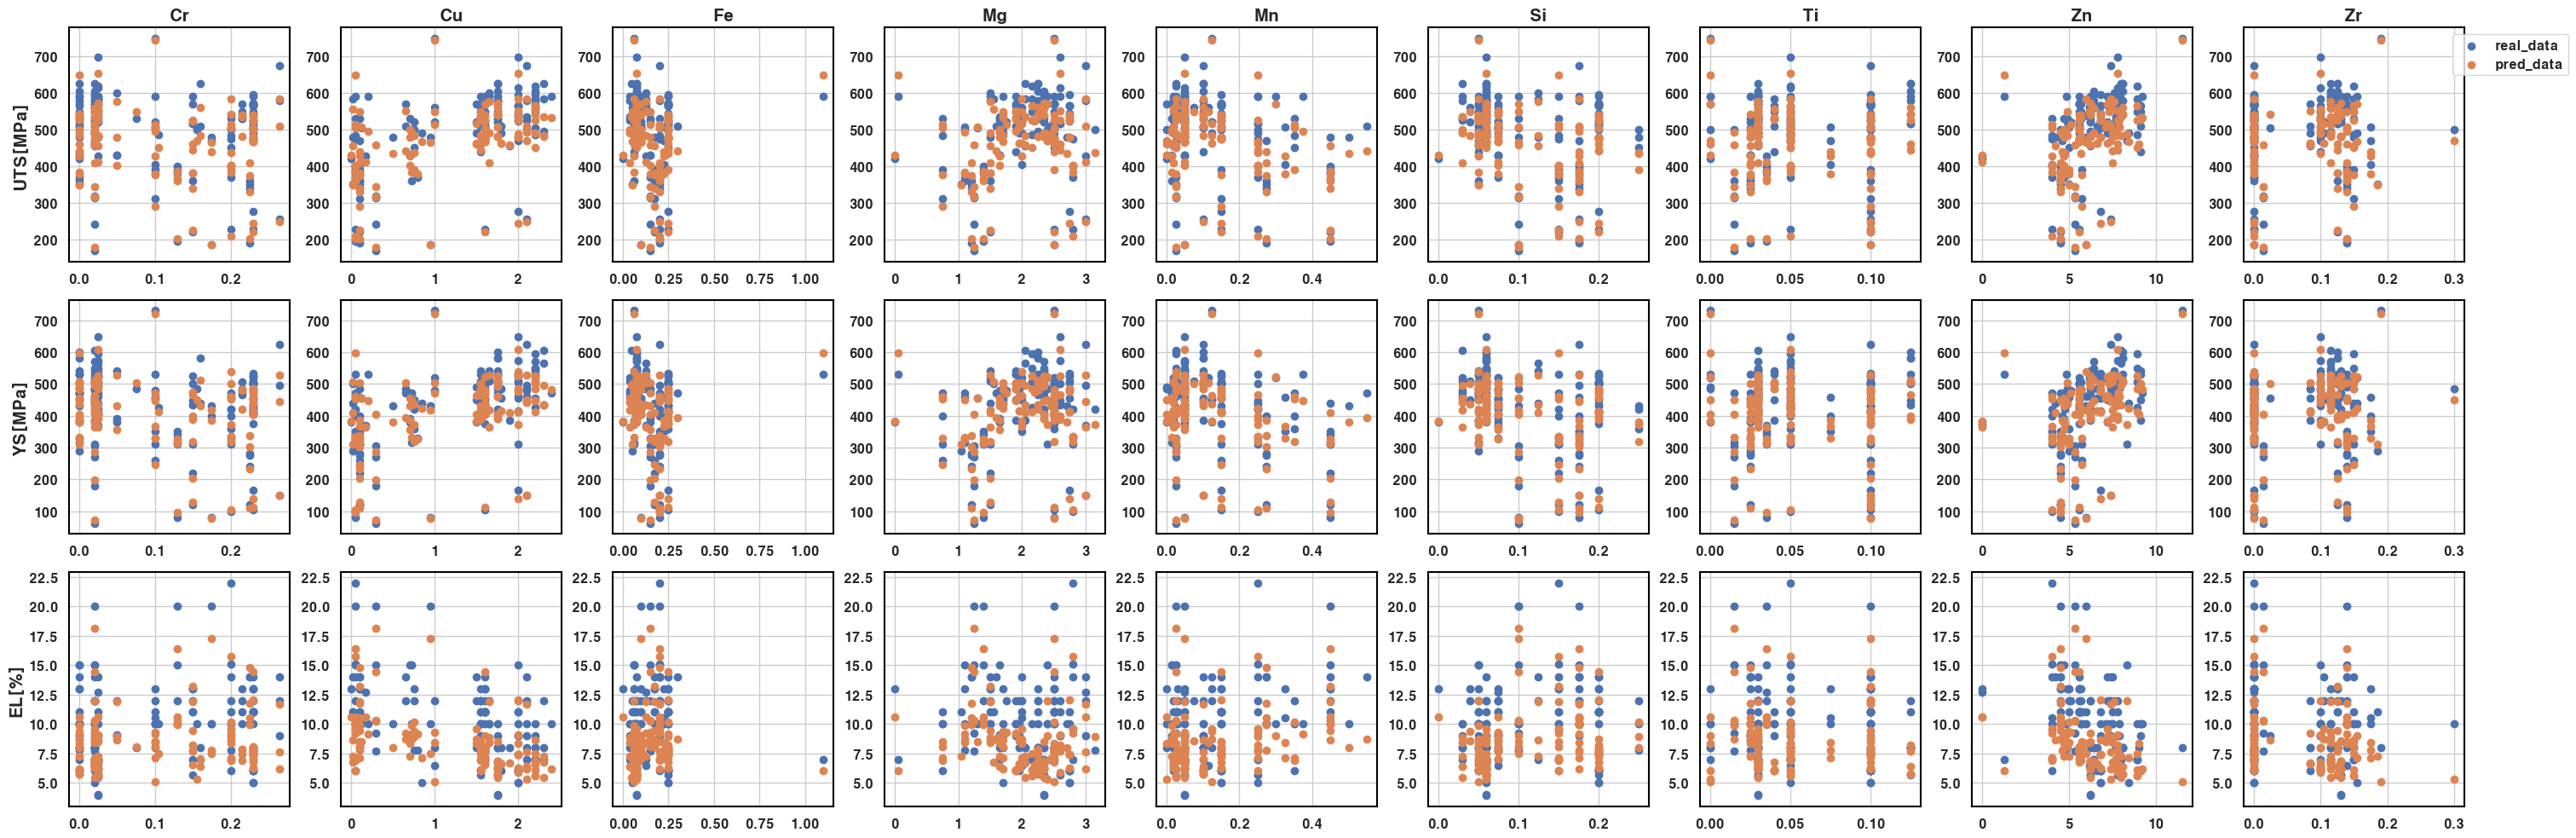

In [424]:
# 모델을 사용하여 예측값 얻기
predicted_values_bayesian = best_model.predict(X_scaled)
predicted_uts_bayesian = predicted_values_bayesian[:, 0]  # 예측된 UTS 값
predicted_ys_bayesian = predicted_values_bayesian[:, 1]   # 예측된 YS 값
predicted_el_bayesian = predicted_values_bayesian[:, 2]   # 예측된 EL 값

# 3x9 서브플롯 그래프 그리기
fig, axs = plt.subplots(3, len(element_indices), figsize=(30, 10))

# 각 원소별로 그래프 그리기
for row, property_name in enumerate(['UTS[MPa]', 'YS[MPa]', 'EL[%]']):
    for col, element_idx in enumerate(element_indices):
        element_name = element_names[element_idx]
        ax = axs[row, col]
        
        if col == 0:
            ax.set_ylabel(property_name, fontsize=14, fontweight='bold')  # 왼쪽에 한 번만 bold체로 ylabel 설정
        if row == 0:
            ax.set_title(f'{element_name}', fontsize=14, fontweight='bold')  # 맨 위에 한 번만 bold체로 title 설정
        
        ax.scatter(experiment_data[:, element_idx], y[:, row], label='real_data')
        
        if property_name == 'UTS[MPa]':
            predicted_property = predicted_uts_bayesian
        elif property_name == 'YS[MPa]':
            predicted_property = predicted_ys_bayesian
        else:
            predicted_property = predicted_el_bayesian
        
        ax.scatter(experiment_data[:, element_idx], predicted_property, label='pred_data')
        
        # 테두리 선 색상 어둡게 설정
        for spine in ax.spines.values():
            spine.set_edgecolor('black')  # 색상 설정
            spine.set_linewidth(1.5)  # 굵기 설정
        
        # 맨 오른쪽 위 서브플롯에만 legend 추가
        if row == 0 and col == len(element_indices) - 1:
            ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), prop={'weight': 'bold'})  # 여기서 위치 조정

        # x, y 축 눈금 라벨 굵게 설정
        for label in ax.get_xticklabels():
            label.set_fontweight('bold')
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')

# 여백 조정
plt.subplots_adjust(right=0.8)  # 여백을 오른쪽으로 조정

plt.tight_layout()
plt.show()

In [425]:
# 모델을 사용하여 예측값 얻기
predicted_values_bayesian = model_bayesian.predict(X_scaled)
predicted_uts_bayesian = predicted_values_bayesian[:, 0]  # 예측된 UTS 값
predicted_ys_bayesian = predicted_values_bayesian[:, 1]   # 예측된 YS 값
predicted_el_bayesian = predicted_values_bayesian[:, 2]   # 예측된 EL 값

# 3x3 figure 생성
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

# Bold체 폰트 생성
bold_font = {'fontweight': 'bold'}

# Legend 폰트 생성
legend_font = FontProperties(weight='bold')

# 'A', 'T4', 'T5', 'T6', 'T7' 속성의 UTS, YS, EL 값 (swarmplot)
for row in range(3):
    for col, attr_idx in enumerate(attribute_indices_A_T7):
        attribute_name = attribute_names[attr_idx]
        real_data = y[:, row]
        predicted_data = predicted_uts_bayesian if row == 0 else predicted_ys_bayesian if row == 1 else predicted_el_bayesian
        mask = (X_scaled[:, normalized_experiment_data.shape[1] + attr_idx] == 1)
        
        axs[row, 0].set_ylabel('UTS [MPa]' if row == 0 else 'YS [MPa]' if row == 1 else 'EL [%]', **bold_font)
        
        sns.swarmplot(x=np.repeat(f"{attribute_name} (Real)", np.sum(mask)), y=real_data[mask], ax=axs[row, 0], color='blue', alpha=0.5, label='Real Data', legend=False)
        sns.swarmplot(x=np.repeat(f"{attribute_name} (Predicted)", np.sum(mask)), y=predicted_data[mask], ax=axs[row, 0], color='red', alpha=0.5, label='Predicted Data', legend=False)

    # xticklabels 없애기
    axs[row, 0].set_xticklabels([])
    
    # y ticks label 굵게 설정
    for label in axs[row, 0].get_yticklabels():
        label.set_fontweight('bold')
    
    # xticks 없애기
    axs[row, 0].set_xticks([])

# ...

# 'stress-relieved by stretching' 속성의 UTS, YS, EL 값 (swarmplot)
for row in range(3):
    real_data = y[:, row]
    predicted_data = predicted_uts_bayesian if row == 0 else predicted_ys_bayesian if row == 1 else predicted_el_bayesian

    # 속성값이 0인 데이터 플롯 (Real)
    mask_0 = (X_scaled[:, normalized_experiment_data.shape[1] + attribute_index_stress_relieved] == 0)
    sns.swarmplot(x=np.repeat('stress-relieved by stretching (0) (Real)', np.sum(mask_0)), y=real_data[mask_0], ax=axs[row, 1], color='blue', alpha=0.5, label='Real Data', legend=False)

    # 속성값이 0인 데이터 플롯 (Predicted)
    sns.swarmplot(x=np.repeat('stress-relieved by stretching (0) (Predicted)', np.sum(mask_0)), y=predicted_data[mask_0], ax=axs[row, 1], color='red', alpha=0.5, label='Predicted Data', legend=False)

    # 속성값이 1인 데이터 플롯 (Real)
    mask_1 = (X_scaled[:, normalized_experiment_data.shape[1] + attribute_index_stress_relieved] == 1)
    sns.swarmplot(x=np.repeat('stress-relieved by stretching (1) (Real)', np.sum(mask_1)), y=real_data[mask_1], ax=axs[row, 1], color='blue', alpha=0.5, legend=False)

    # 속성값이 1인 데이터 플롯 (Predicted)
    sns.swarmplot(x=np.repeat('stress-relieved by stretching (1) (Predicted)', np.sum(mask_1)), y=predicted_data[mask_1], ax=axs[row, 1], color='red', alpha=0.5, legend=False)
    
    # xticklabels 없애기
    axs[row, 1].set_xticklabels([])
    
    # y ticks label 굵게 설정
    for label in axs[row, 1].get_yticklabels():
        label.set_fontweight('bold')
    
    # xticks 없애기
    axs[row, 1].set_xticks([])

# ...

# 'AHT' 속성의 UTS, YS, EL 값 (swarmplot)
for row in range(3):
    attribute_name = 'AHT'
    real_data = y[:, row]
    predicted_data = predicted_uts_bayesian if row == 0 else predicted_ys_bayesian if row == 1 else predicted_el_bayesian

    # 속성값이 0인 데이터 플롯 (Real)
    mask_0 = (X_scaled[:, normalized_experiment_data.shape[1] + attribute_index_AHT] == 0)
    sns.swarmplot(x=np.repeat('AHT (0) (Real)', np.sum(mask_0)), y=real_data[mask_0], ax=axs[row, 2], color='blue', alpha=0.5, label='Real Data', legend=False)

    # 속성값이 0인 데이터 플롯 (Predicted)
    sns.swarmplot(x=np.repeat('AHT (0) (Predicted)', np.sum(mask_0)), y=predicted_data[mask_0], ax=axs[row, 2], color='red', alpha=0.5, label='Predicted Data', legend=False)

    # 속성값이 1인 데이터 플롯 (Real)
    mask_1 = (X_scaled[:, normalized_experiment_data.shape[1] + attribute_index_AHT] == 1)
    sns.swarmplot(x=np.repeat('AHT (1) (Real)', np.sum(mask_1)), y=real_data[mask_1], ax=axs[row, 2], color='blue', alpha=0.5, legend=False)

    # 속성값이 1인 데이터 플롯 (Predicted)
    sns.swarmplot(x=np.repeat('AHT (1) (Predicted)', np.sum(mask_1)), y=predicted_data[mask_1], ax=axs[row, 2], color='red', alpha=0.5, legend=False)

    # xticklabels 없애기
    axs[row, 2].set_xticklabels([])
    
    # y ticks label 굵게 설정
    for label in axs[row, 2].get_yticklabels():
        label.set_fontweight('bold')
    
    # xticks 없애기
    axs[row, 2].set_xticks([])

# 범례 설정은 ax[0,2]에만 적용
axs[0, 2].legend(loc='upper right', bbox_to_anchor=(1.7, 1.0), prop={'weight': 'bold'})

# 테두리를 검은색으로 설정
for ax in axs.flat:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')  # 테두리 색상 설정
        spine.set_linewidth(1.5)  # 테두리 굵기 설정

# 서브플롯의 제목 설정
axs[0, 0].set_title('Aging', fontweight='bold')
axs[0, 1].set_title('Stress-relieved by stretching', fontweight='bold')
axs[0, 2].set_title('Additional Heat treatment', fontweight='bold')

plt.tight_layout()
plt.show()


5/5 [==============================] - 0s 2ms/step


TypeError: list indices must be integers or slices, not tuple

1/1 [==============================] - 0s 25ms/step


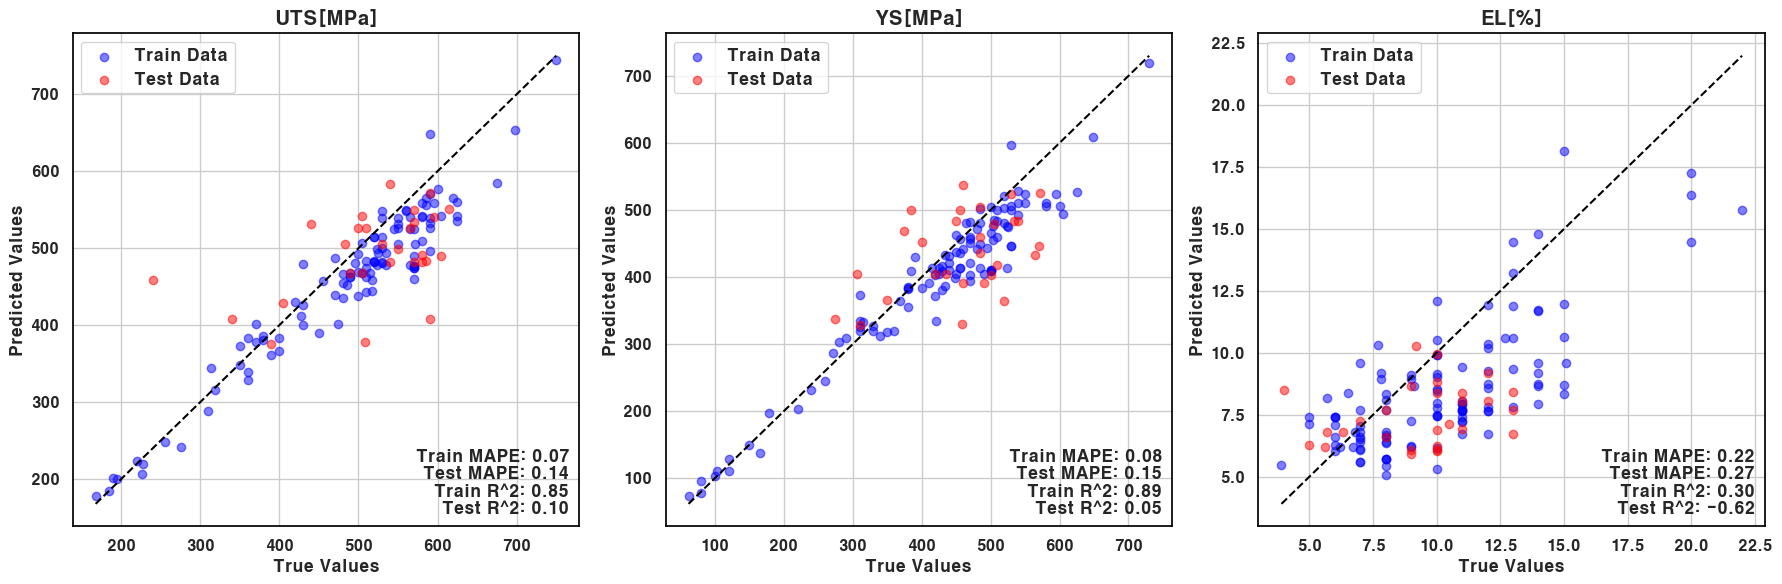

In [421]:
# Calculate predictions using the best model
predicted_train_values_best = best_model.predict(X_train)
predicted_train_uts_best = predicted_train_values_best[:, 0]
predicted_train_ys_best = predicted_train_values_best[:, 1]
predicted_train_el_best = predicted_train_values_best[:, 2]

predicted_test_values_best = best_model.predict(X_test)
predicted_test_uts_best = predicted_test_values_best[:, 0]
predicted_test_ys_best = predicted_test_values_best[:, 1]
predicted_test_el_best = predicted_test_values_best[:, 2]

# Create subplots and evaluate best_model's performance
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plot_and_evaluate_combined(y_train[:, 0], predicted_train_uts_best, y_test[:, 0], predicted_test_uts_best, 'UTS[MPa]', axs[0])
plot_and_evaluate_combined(y_train[:, 1], predicted_train_ys_best, y_test[:, 1], predicted_test_ys_best, 'YS[MPa]', axs[1])
plot_and_evaluate_combined(y_train[:, 2], predicted_train_el_best, y_test[:, 2], predicted_test_el_best, 'EL[%]', axs[2])

plt.tight_layout()
plt.show()


In [342]:
# print( predicted_train_values[0][:, 0])
# print(predicted_train_values[1][:, 0])

print(predicted_train_values[2][:, 0])

[ 3.7176638  5.8992167 10.025498   8.952279  13.462388   9.870355
 10.284204   9.925691   6.20807    3.7453928  8.139672   8.680886
  4.99261   12.054093   7.75834    4.2631464 10.9028635 19.495064
  4.7691355  8.8740015 11.0369425 10.796754   7.081979   8.054818
  7.053582  11.0896845 12.9779825  9.870355   6.20807   13.157983
 12.69201    7.763955   8.342797   9.378236   8.187814   7.263734
  7.520341  11.174226  13.030435  11.382417  10.284204   8.470712
  8.324685  14.037995  13.267388   6.752862  11.092309   8.39816
  7.848878  11.392541   8.388177   7.5748606 12.908074   6.532151
  8.803163   8.892976   4.7691355 12.182374   8.021562   9.563638
  7.1671915  9.957856   6.66385    4.6600122 12.749749   7.252595
  7.043      9.807145   7.043      8.511163   9.925691   9.870355
  9.563638   9.106271   7.6093836 10.056237   7.050912  13.443597
  7.5287867  9.586648   9.431787   8.955575   9.611245  13.700135
  6.20807    8.985818   6.961854   8.8740015 10.076814  10.345971
  9.299546 

In [ ]:
from tensorflow.keras.models import save_model, load_model

# Save the model_bayesian
model_bayesian.save('model_bayesian.h5')

# Load the saved model
model_bayesian = load_model('model_bayesian.h5')

# Now you can use the loaded model for uncertainty estimation


In [ ]:
# Perform predictions with uncertainty estimation
predictions_bayesian = predict_with_uncertainty(model_bayesian, x_input, num_samples)

# Calculate mean and standard deviation for each output
prediction_mean_bayesian = np.mean(predictions_bayesian, axis=0)[:, 0]  # Adjust indexing here
prediction_std_bayesian = np.std(predictions_bayesian, axis=0)[:, 0]  # Adjust indexing here

# Visualize the predictions and uncertainty for Bayesian Model
output_labels = ['UTS', 'YS', 'EL']  # Assuming UTS, YS, and EL are the outputs
num_outputs = len(output_labels)



5/5 [==============================] - 0s 2ms/step


ValueError: 'y1' is not 1-dimensional

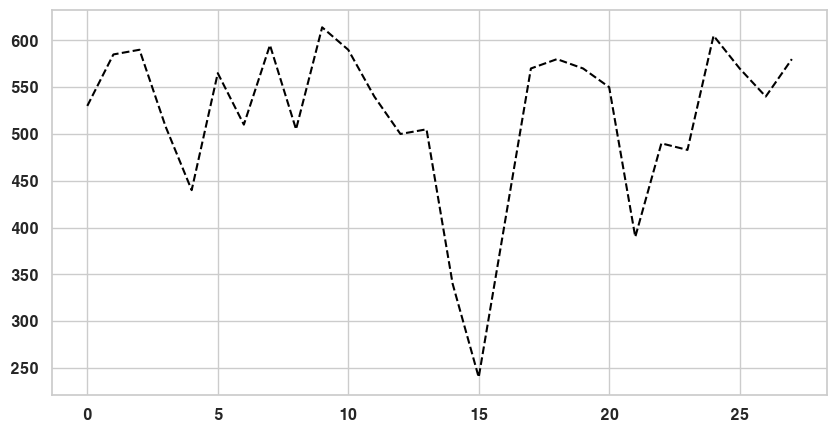

In [ ]:
sample_indices = np.arange(len(y_test))  # Create an array of sample indices
# Calculate mean and standard deviation for each output
prediction_mean_bayesian = np.mean(predictions_bayesian, axis=0)
prediction_std_bayesian = np.std(predictions_bayesian, axis=0)

for i in range(num_outputs):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test[:, i], label=f'True {output_labels[i]}', color='black', linestyle='--')
    plt.fill_between(sample_indices, prediction_mean_bayesian[:, i] - prediction_std_bayesian[:, i],
                     prediction_mean_bayesian[:, i] + prediction_std_bayesian[:, i],
                     color='orange', alpha=0.2)
    plt.xlabel('Sample Index')
    plt.ylabel(output_labels[i])
    plt.title(f'Bayesian Model: {output_labels[i]} Prediction with Uncertainty')
    plt.legend()
    plt.show()


In [ ]:
print(prediction_mean_bayesian[:, i])
print(prediction_std_bayesian[:, i])

[343.05423 252.54445   9.24939]
[4.5776367e-04 3.0517578e-05 0.0000000e+00]
